In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import sys
import os
from scipy import stats

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)
from scripts.utils import execute_query

# Set styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [2]:
# 1: Load Data from Marts
print("Loading data from Snowflake MARTS layer...")

# Load daily aggregates
query_daily = "SELECT * FROM MARTS.FCT_WEATHER_DAILY"
df_daily = execute_query(query_daily, config_path='../config/snowflake_config.json')

# Load features for ML
query_features = "SELECT * FROM MARTS.FCT_WEATHER_FEATURES LIMIT 50000"
df_features = execute_query(query_features, config_path='../config/snowflake_config.json')

print(f"✅ Daily data: {df_daily.shape}")
print(f"✅ Features data: {df_features.shape}")

numeric_cols = [
    'avg_temperature',
    'total_precipitation',
    'avg_humidity',
    'avg_wind_speed'
]

df_daily[numeric_cols] = df_daily[numeric_cols].apply(
    pd.to_numeric, errors='coerce'
)



Loading data from Snowflake MARTS layer...
🔍 Executing query...
✅ Query returned 3,655 rows
🔍 Executing query...
✅ Query returned 3,650 rows
✅ Daily data: (3655, 46)
✅ Features data: (3650, 48)


In [3]:
# 2: Temperature Analysis by Location
print("=" * 80)
print("TEMPERATURE ANALYSIS BY LOCATION")
print("=" * 80)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average Temperature by Location', 
                   'Temperature Distribution',
                   'Temperature Trends Over Time',
                   'Temperature Range by Month'),
    specs=[[{"type": "bar"}, {"type": "box"}],
           [{"type": "scatter"}, {"type": "box"}]]
)

# 1. Average temperature by location
avg_by_loc = df_daily.groupby('location_name')['avg_temperature'].mean().sort_values()
fig.add_trace(
    go.Bar(x=avg_by_loc.values, y=avg_by_loc.index, orientation='h', 
           marker_color='coral', name='Avg Temp'),
    row=1, col=1
)

# 2. Temperature distribution by location
for location in df_daily['location_name'].unique():
    loc_data = df_daily[df_daily['location_name'] == location]
    fig.add_trace(
        go.Box(y=loc_data['avg_temperature'], name=location),
        row=1, col=2
    )

# 3. Temperature trends over time
for location in df_daily['location_name'].unique():
    loc_data = df_daily[df_daily['location_name'] == location].sort_values('date')
    fig.add_trace(
        go.Scatter(x=loc_data['date'], y=loc_data['avg_temperature'], 
                  mode='lines', name=location),
        row=2, col=1
    )

# 4. Temperature range by month
monthly_data = df_daily.groupby('month').agg({
    'avg_temperature': 'mean',
    'max_temperature': 'max',
    'min_temperature': 'min'
}).reset_index()

for location in df_daily['location_name'].unique():
    loc_monthly = df_daily[df_daily['location_name'] == location].groupby('month')['avg_temperature'].mean()
    fig.add_trace(
        go.Box(x=df_daily[df_daily['location_name'] == location]['month'], 
               y=df_daily[df_daily['location_name'] == location]['avg_temperature'],
               name=location),
        row=2, col=2
    )

fig.update_layout(height=1000, showlegend=True, title_text="Temperature Analysis")
fig.show()

# Statistical summary
print("\nTemperature Statistics by Location:")
temp_stats = df_daily.groupby('location_name')['avg_temperature'].describe()
display(temp_stats)

TEMPERATURE ANALYSIS BY LOCATION



Temperature Statistics by Location:


,count,mean,std,min,25%,50%,75%,max
location_name,,,,,,,,
Can Tho,731.0,27.165732,1.473488,22.19,26.195,26.99,27.970,32.66
Da Nang,731.0,26.305691,3.443164,18.03,23.555,26.70,28.965,33.38
Hai Phong,731.0,24.157811,4.871218,7.38,20.270,25.56,28.060,32.00
Hanoi,731.0,24.163461,4.969527,8.01,20.395,25.74,27.950,32.61
Ho Chi Minh City,731.0,27.726197,1.528973,23.67,26.590,27.45,28.700,32.55


SEASONAL PATTERNS ANALYSIS


C:\Users\Pearson\AppData\Local\Temp\ipykernel_8984\2964990292.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




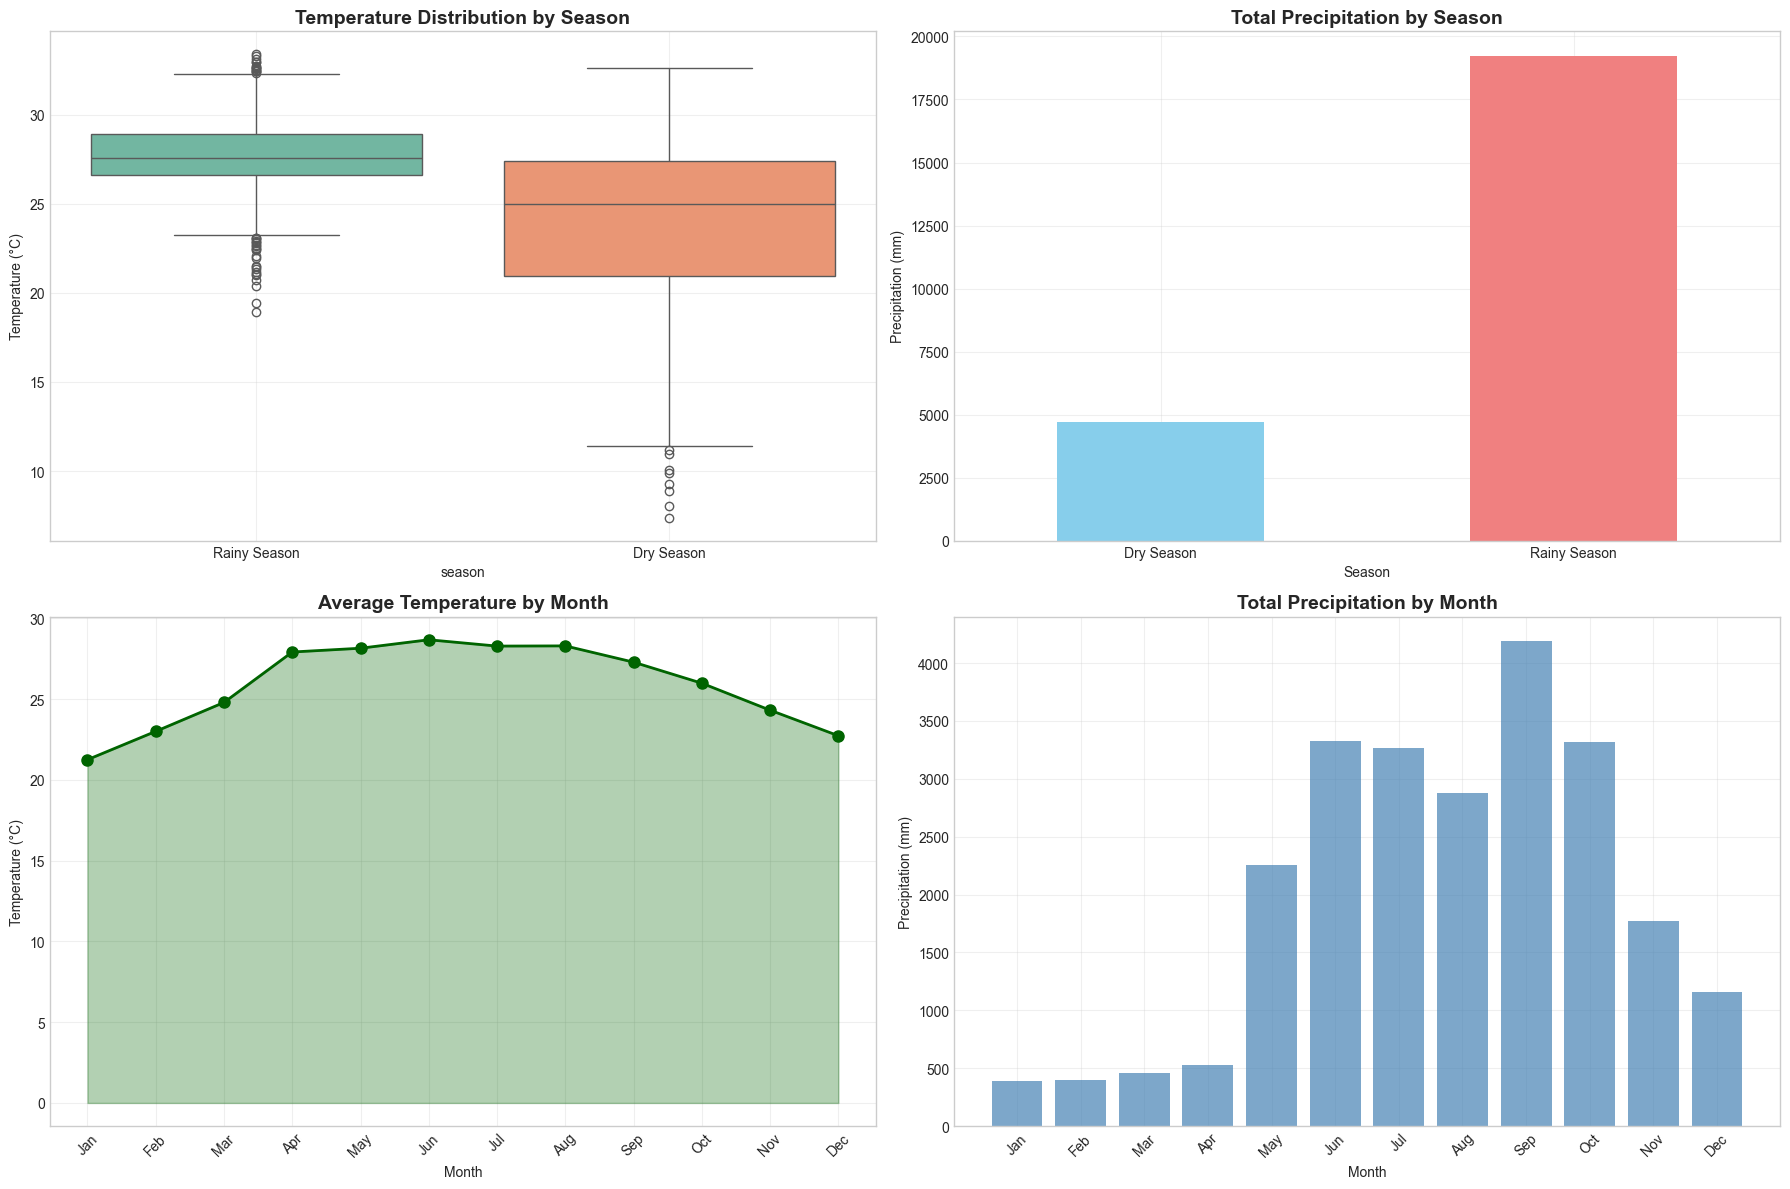


Seasonal Statistics:


avg_temperature                     total_precipitation         \
                        mean   std    min    max                 sum   mean   
season                                                                        
Dry Season             24.00  4.46   7.38  32.61              4704.1   2.59   
Rainy Season           27.78  1.85  18.92  33.38             19240.6  10.46   

             avg_humidity avg_wind_speed  
                     mean           mean  
season                                    
Dry Season          76.73           9.11  
Rainy Season        83.09           8.49

In [4]:
# 3: Seasonal Patterns
print("=" * 80)
print("SEASONAL PATTERNS ANALYSIS")
print("=" * 80)

# Group by season and month
seasonal_data = df_daily.groupby(['season', 'month']).agg({
    'avg_temperature': ['mean', 'std'],
    'total_precipitation': 'sum',
    'avg_humidity': 'mean',
    'avg_wind_speed': 'mean'
}).reset_index()

seasonal_data.columns = ['_'.join(col).strip('_') for col in seasonal_data.columns.values]

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Temperature by season
sns.boxplot(data=df_daily, x='season', y='avg_temperature', ax=axes[0,0], palette='Set2')
axes[0,0].set_title('Temperature Distribution by Season', fontweight='bold', fontsize=14)
axes[0,0].set_ylabel('Temperature (°C)')
axes[0,0].grid(alpha=0.3)

# Precipitation by season
season_precip = df_daily.groupby('season')['total_precipitation'].sum()
season_precip.plot(kind='bar', ax=axes[0,1], color=['skyblue', 'lightcoral'])
axes[0,1].set_title('Total Precipitation by Season', fontweight='bold', fontsize=14)
axes[0,1].set_ylabel('Precipitation (mm)')
axes[0,1].set_xlabel('Season')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].grid(alpha=0.3)

# Monthly temperature pattern
monthly_temp = df_daily.groupby('month')['avg_temperature'].mean()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[1,0].plot(range(1, 13), monthly_temp.values, marker='o', linewidth=2, markersize=8, color='darkgreen')
axes[1,0].set_title('Average Temperature by Month', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Temperature (°C)')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].set_xticklabels(months, rotation=45)
axes[1,0].grid(alpha=0.3)
axes[1,0].fill_between(range(1, 13), monthly_temp.values, alpha=0.3, color='darkgreen')

# Monthly precipitation pattern
monthly_precip = df_daily.groupby('month')['total_precipitation'].sum()
axes[1,1].bar(range(1, 13), monthly_precip.values, color='steelblue', alpha=0.7)
axes[1,1].set_title('Total Precipitation by Month', fontweight='bold', fontsize=14)
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Precipitation (mm)')
axes[1,1].set_xticks(range(1, 13))
axes[1,1].set_xticklabels(months, rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSeasonal Statistics:")
seasonal_stats = df_daily.groupby('season').agg({
    'avg_temperature': ['mean', 'std', 'min', 'max'],
    'total_precipitation': ['sum', 'mean'],
    'avg_humidity': 'mean',
    'avg_wind_speed': 'mean'
}).round(2)
display(seasonal_stats)

PRECIPITATION ANALYSIS


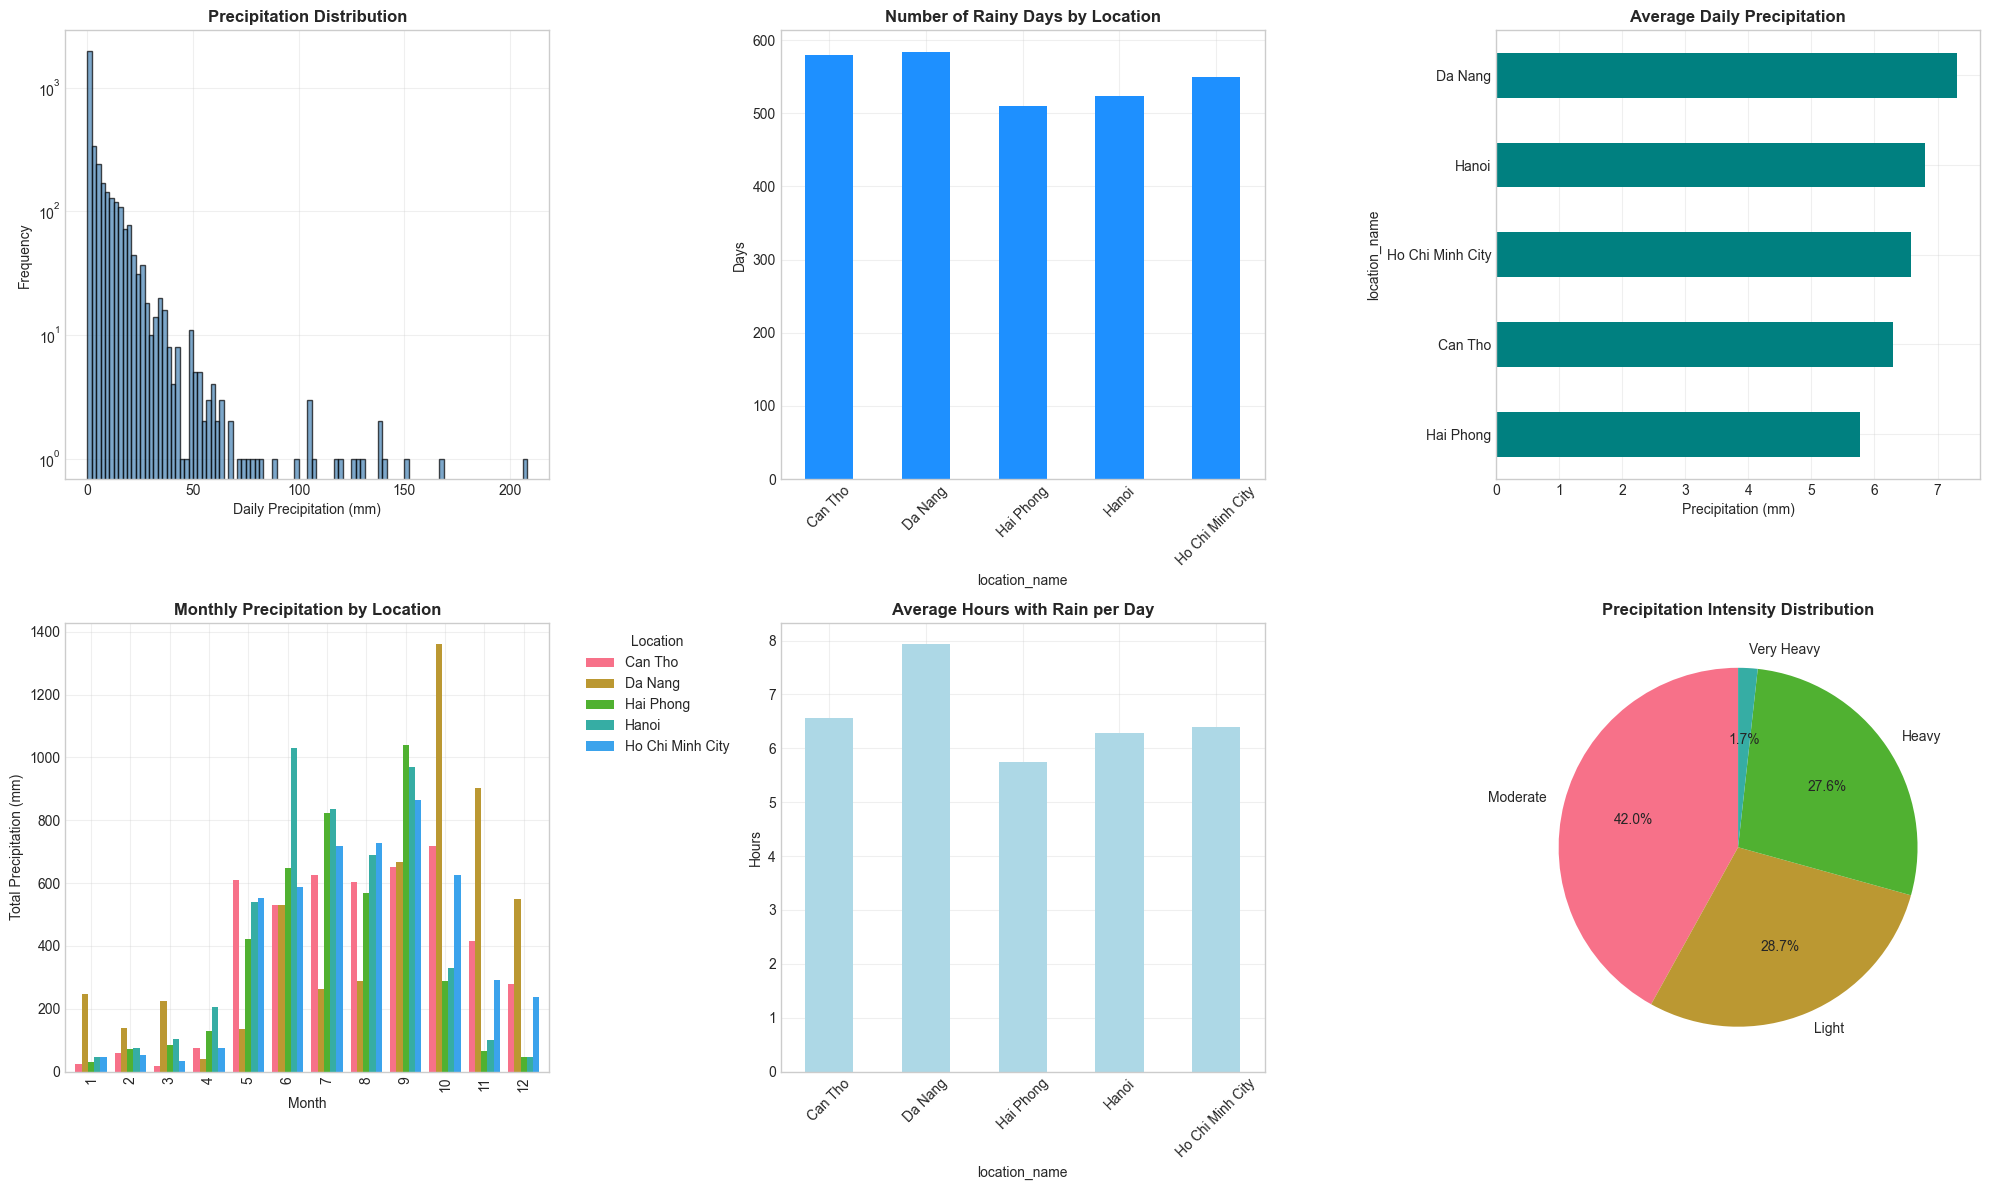


Precipitation Statistics:


,count,mean,std,min,25%,50%,75%,max
location_name,,,,,,,,
Can Tho,731.0,6.298085,7.785188,0.0,0.1,3.4,10.25,47.2
Da Nang,731.0,7.308071,17.524177,0.0,0.2,1.6,5.90,168.4
Hai Phong,731.0,5.772640,13.969917,0.0,0.0,0.8,5.55,208.2
Hanoi,731.0,6.802326,14.260725,0.0,0.0,0.8,6.90,139.1
Ho Chi Minh City,731.0,6.574966,8.668723,0.0,0.1,2.7,10.90,67.7


In [5]:
# 4: Precipitation Patterns
print("=" * 80)
print("PRECIPITATION ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Precipitation distribution
axes[0,0].hist(df_daily['total_precipitation'], bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[0,0].set_title('Precipitation Distribution', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('Daily Precipitation (mm)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_yscale('log')
axes[0,0].grid(alpha=0.3)

# 2. Rainy days by location
rainy_days = df_daily[df_daily['total_precipitation'] > 0].groupby('location_name').size()
rainy_days.plot(kind='bar', ax=axes[0,1], color='dodgerblue')
axes[0,1].set_title('Number of Rainy Days by Location', fontweight='bold', fontsize=12)
axes[0,1].set_ylabel('Days')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(alpha=0.3)

# 3. Average daily precipitation by location
avg_precip = df_daily.groupby('location_name')['total_precipitation'].mean().sort_values()
avg_precip.plot(kind='barh', ax=axes[0,2], color='teal')
axes[0,2].set_title('Average Daily Precipitation', fontweight='bold', fontsize=12)
axes[0,2].set_xlabel('Precipitation (mm)')
axes[0,2].grid(alpha=0.3)

# 4. Precipitation by month
monthly_precip_by_loc = df_daily.groupby(['month', 'location_name'])['total_precipitation'].sum().unstack()
monthly_precip_by_loc.plot(kind='bar', ax=axes[1,0], width=0.8)
axes[1,0].set_title('Monthly Precipitation by Location', fontweight='bold', fontsize=12)
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Total Precipitation (mm)')
axes[1,0].legend(title='Location', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1,0].grid(alpha=0.3)

# 5. Hours with rain
hours_rain = df_daily.groupby('location_name')['hours_with_rain'].mean()
hours_rain.plot(kind='bar', ax=axes[1,1], color='lightblue')
axes[1,1].set_title('Average Hours with Rain per Day', fontweight='bold', fontsize=12)
axes[1,1].set_ylabel('Hours')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

# 6. Precipitation intensity categories
precip_categories = pd.cut(df_daily['total_precipitation'], 
                           bins=[0, 1, 10, 50, 200], 
                           labels=['Light', 'Moderate', 'Heavy', 'Very Heavy'])
precip_categories.value_counts().plot(kind='pie', ax=axes[1,2], autopct='%1.1f%%', startangle=90)
axes[1,2].set_title('Precipitation Intensity Distribution', fontweight='bold', fontsize=12)
axes[1,2].set_ylabel('')

plt.tight_layout()
plt.show()

print("\nPrecipitation Statistics:")
precip_stats = df_daily.groupby('location_name')['total_precipitation'].describe()
display(precip_stats)

WIND ANALYSIS


C:\Users\Pearson\AppData\Local\Temp\ipykernel_8984\1199877487.py:29: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




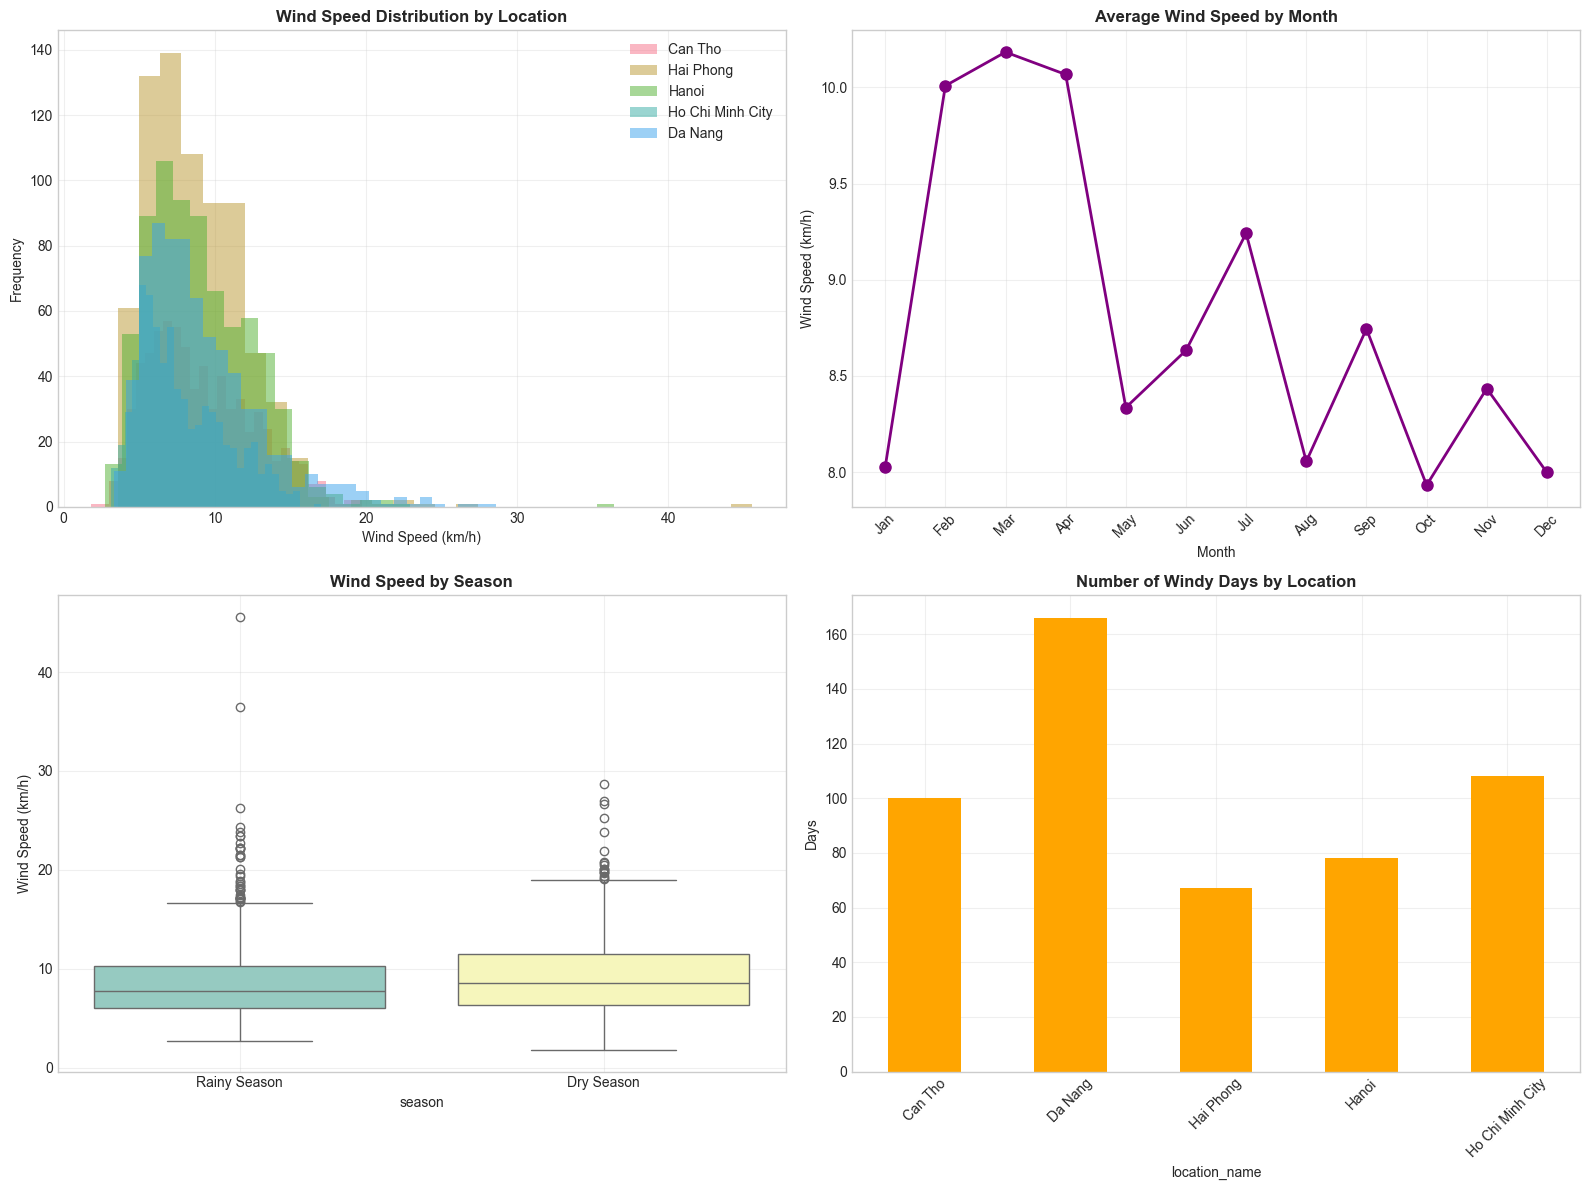


Wind Statistics:


,count,mean,std,min,25%,50%,75%,max
location_name,,,,,,,,
Can Tho,731.0,9.119699,3.447605,1.80,6.445,8.47,11.445,19.76
Da Nang,731.0,9.210027,3.945475,3.31,6.450,8.23,11.085,28.63
Hai Phong,731.0,8.792777,3.459786,3.60,6.310,8.21,10.785,45.58
Hanoi,731.0,9.046963,3.508662,2.75,6.470,8.46,11.370,36.42
Ho Chi Minh City,731.0,7.804254,2.859782,3.15,5.550,7.04,9.710,17.05


In [6]:
# 5: Wind Analysis
print("=" * 80)
print("WIND ANALYSIS")
print("=" * 80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Wind speed distribution by location
for location in df_daily['location_name'].unique():
    loc_data = df_daily[df_daily['location_name'] == location]['avg_wind_speed']
    axes[0,0].hist(loc_data, bins=30, alpha=0.5, label=location)
axes[0,0].set_title('Wind Speed Distribution by Location', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('Wind Speed (km/h)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# 2. Average wind speed by month
monthly_wind = df_daily.groupby('month')['avg_wind_speed'].mean()
axes[0,1].plot(range(1, 13), monthly_wind.values, marker='o', linewidth=2, markersize=8, color='purple')
axes[0,1].set_title('Average Wind Speed by Month', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Wind Speed (km/h)')
axes[0,1].set_xticks(range(1, 13))
axes[0,1].set_xticklabels(months, rotation=45)
axes[0,1].grid(alpha=0.3)

# 3. Wind speed by season
sns.boxplot(data=df_daily, x='season', y='avg_wind_speed', ax=axes[1,0], palette='Set3')
axes[1,0].set_title('Wind Speed by Season', fontweight='bold', fontsize=12)
axes[1,0].set_ylabel('Wind Speed (km/h)')
axes[1,0].grid(alpha=0.3)

# 4. Windy days by location
windy_days = df_daily[df_daily['hours_windy'] > 0].groupby('location_name').size()
windy_days.plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Number of Windy Days by Location', fontweight='bold', fontsize=12)
axes[1,1].set_ylabel('Days')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nWind Statistics:")
wind_stats = df_daily.groupby('location_name')['avg_wind_speed'].describe()
display(wind_stats)

correlation analysis


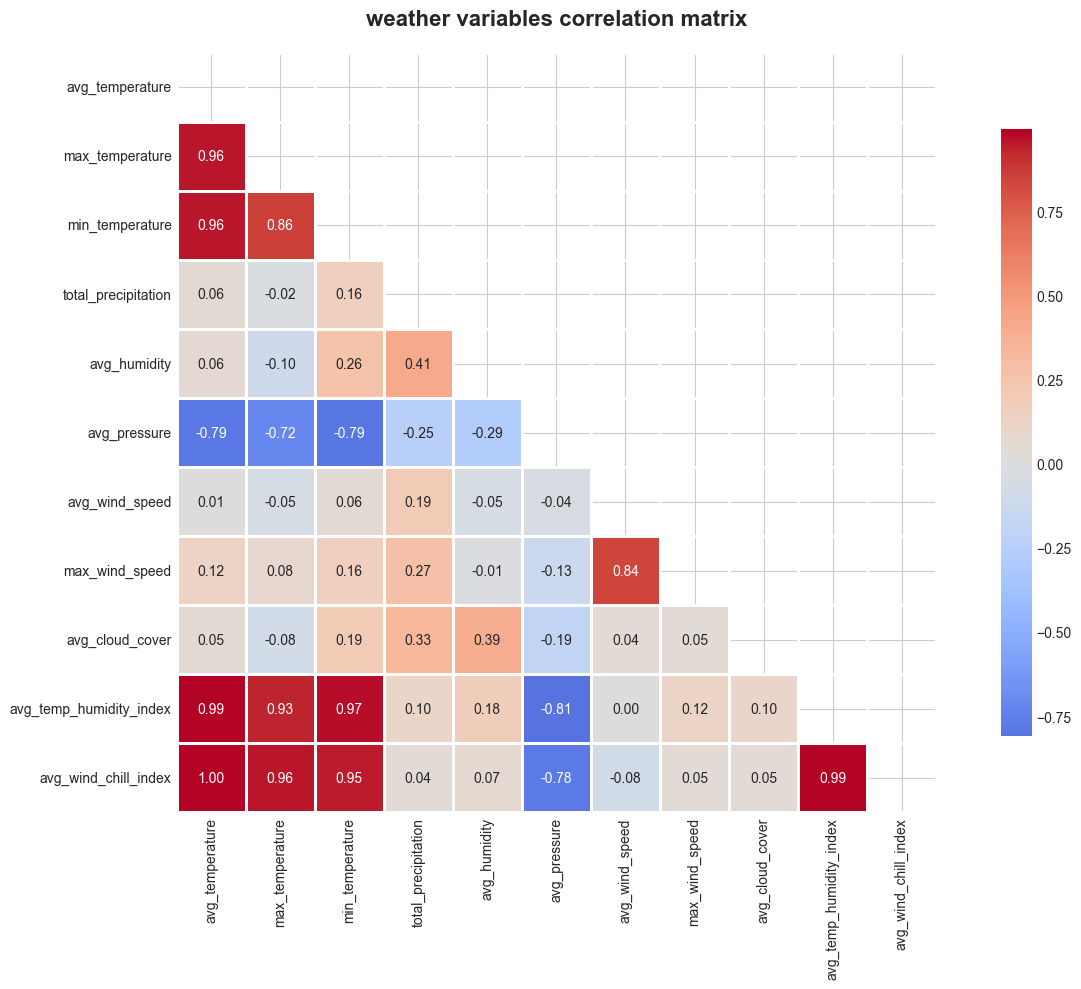


strong correlations (|r| > 0.6):


,variable_1,variable_2,correlation
4,avg_temperature,avg_wind_chill_index,0.995989
3,avg_temperature,avg_temp_humidity_index,0.993329
15,avg_temp_humidity_index,avg_wind_chill_index,0.989879
10,min_temperature,avg_temp_humidity_index,0.973601
8,max_temperature,avg_wind_chill_index,0.959678
0,avg_temperature,max_temperature,0.958219
1,avg_temperature,min_temperature,0.957211
11,min_temperature,avg_wind_chill_index,0.949123
7,max_temperature,avg_temp_humidity_index,0.933473
5,max_temperature,min_temperature,0.855397


In [7]:
# 6: correlation heatmap
print("=" * 80)
print("correlation analysis")
print("=" * 80)

# select numeric columns for correlation
corr_columns = [
    'avg_temperature', 'max_temperature', 'min_temperature',
    'total_precipitation', 'avg_humidity', 'avg_pressure',
    'avg_wind_speed', 'max_wind_speed', 'avg_cloud_cover',
    'avg_temp_humidity_index', 'avg_wind_chill_index'
]

corr_matrix = df_daily[corr_columns].corr()

# create correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8}
)
plt.title(
    'weather variables correlation matrix',
    fontweight='bold',
    fontsize=16,
    pad=20
)
plt.tight_layout()
plt.show()

print("\nstrong correlations (|r| > 0.6):")
strong_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.6:
            strong_corr.append({
                'variable_1': corr_matrix.columns[i],
                'variable_2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

strong_corr_df = (
    pd.DataFrame(strong_corr)
      .sort_values('correlation', ascending=False)
)

display(strong_corr_df)


TIME SERIES DECOMPOSITION


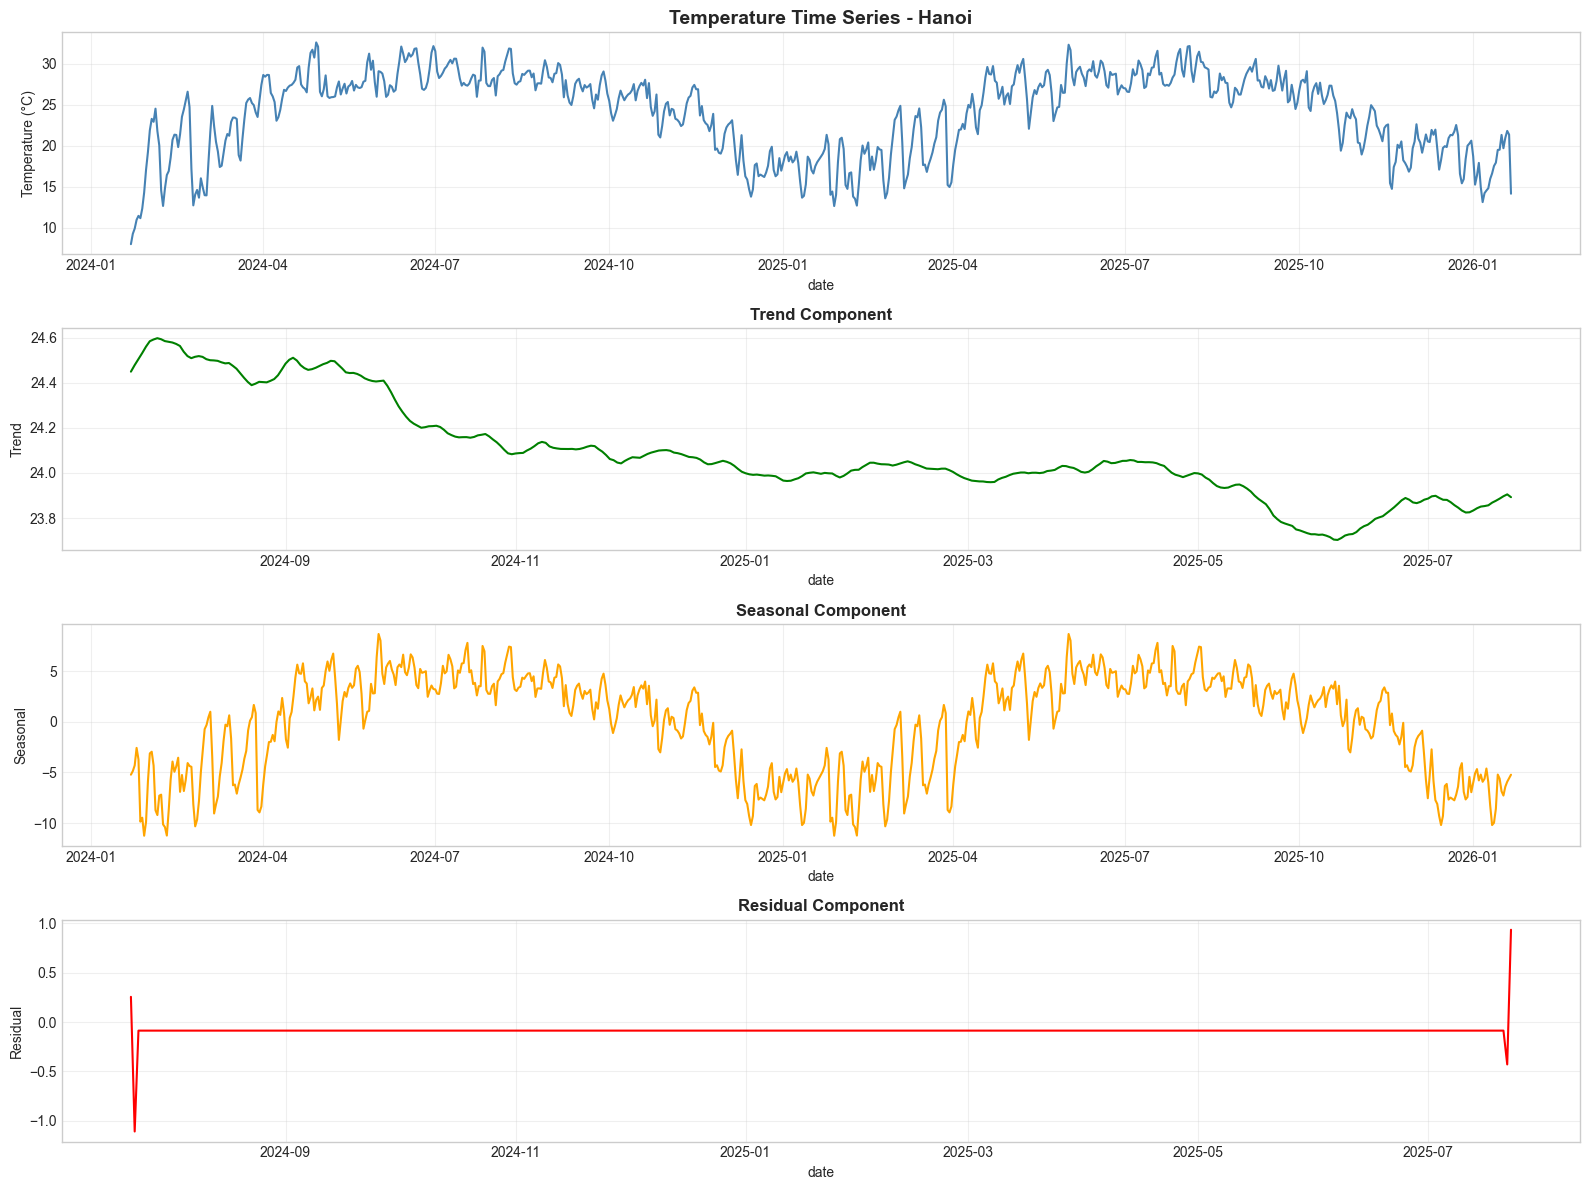

In [8]:
# 7: Time Series Decomposition
print("=" * 80)
print("TIME SERIES DECOMPOSITION")
print("=" * 80)

from statsmodels.tsa.seasonal import seasonal_decompose

# Select one location for decomposition
location = 'Hanoi'
hanoi_data = df_daily[df_daily['location_name'] == location].sort_values('date')
hanoi_data = hanoi_data.set_index('date')

# Decompose temperature
decomposition = seasonal_decompose(hanoi_data['avg_temperature'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

# Original
decomposition.observed.plot(ax=axes[0], color='steelblue')
axes[0].set_title(f'Temperature Time Series - {location}', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(alpha=0.3)

# Trend
decomposition.trend.plot(ax=axes[1], color='green')
axes[1].set_title('Trend Component', fontweight='bold', fontsize=12)
axes[1].set_ylabel('Trend')
axes[1].grid(alpha=0.3)

# Seasonal
decomposition.seasonal.plot(ax=axes[2], color='orange')
axes[2].set_title('Seasonal Component', fontweight='bold', fontsize=12)
axes[2].set_ylabel('Seasonal')
axes[2].grid(alpha=0.3)

# Residual
decomposition.resid.plot(ax=axes[3], color='red')
axes[3].set_title('Residual Component', fontweight='bold', fontsize=12)
axes[3].set_ylabel('Residual')
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

EXTREME WEATHER EVENTS
Temperature Extremes:
  - Hot days threshold (95th percentile): 36.00°C
  - Cold days threshold (5th percentile): 13.35°C

Precipitation Extreme:
  - Heavy rain threshold (95th percentile): 25.50 mm

Wind Extreme:
  - High wind threshold (95th percentile): 22.98 km/h

Extreme Events by Location:


C:\Users\Pearson\AppData\Local\Temp\ipykernel_8984\2282967320.py:21: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Hot Days,Cold Days,Heavy Rain Days,High Wind Days
location_name,,,,
Can Tho,25,0,20,27
Da Nang,62,0,49,76
Hai Phong,9,83,30,22
Hanoi,13,101,56,29
Ho Chi Minh City,82,0,29,29


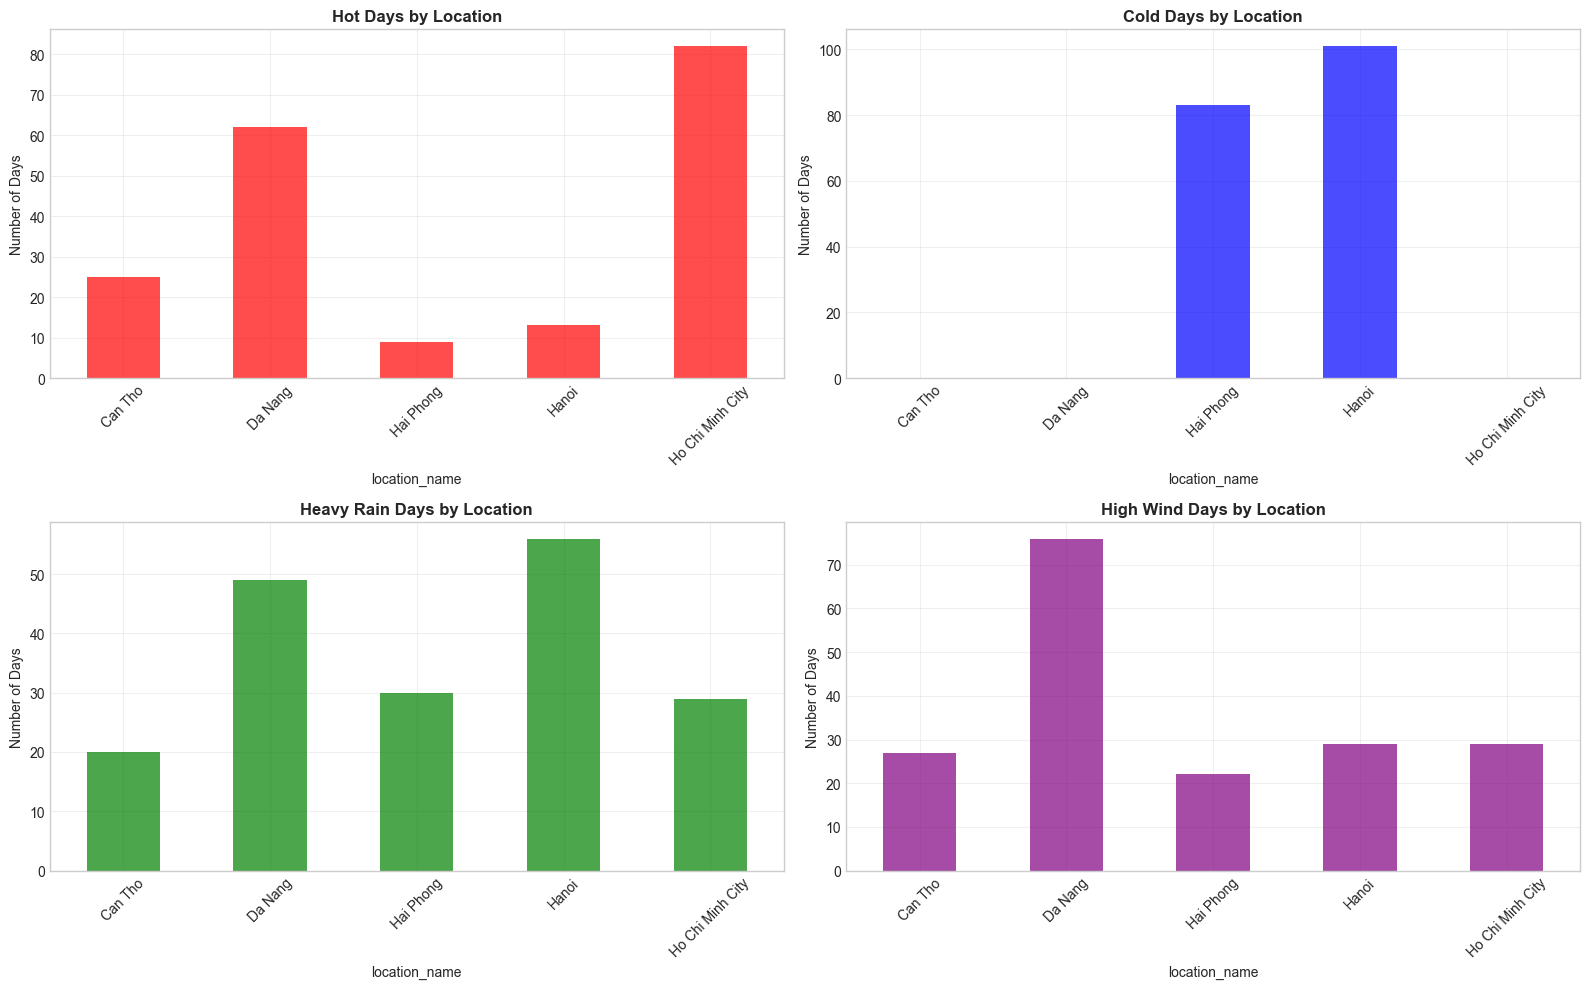

In [9]:
# 8: Weather Extremes Analysis
print("=" * 80)
print("EXTREME WEATHER EVENTS")
print("=" * 80)

# Define thresholds
temp_high = df_daily['max_temperature'].quantile(0.95)
temp_low = df_daily['min_temperature'].quantile(0.05)
precip_high = df_daily['total_precipitation'].quantile(0.95)
wind_high = df_daily['max_wind_speed'].quantile(0.95)

print(f"Temperature Extremes:")
print(f"  - Hot days threshold (95th percentile): {temp_high:.2f}°C")
print(f"  - Cold days threshold (5th percentile): {temp_low:.2f}°C")
print(f"\nPrecipitation Extreme:")
print(f"  - Heavy rain threshold (95th percentile): {precip_high:.2f} mm")
print(f"\nWind Extreme:")
print(f"  - High wind threshold (95th percentile): {wind_high:.2f} km/h")

# Count extreme events by location
extreme_events = df_daily.groupby('location_name').apply(lambda x: pd.Series({
    'Hot Days': (x['max_temperature'] >= temp_high).sum(),
    'Cold Days': (x['min_temperature'] <= temp_low).sum(),
    'Heavy Rain Days': (x['total_precipitation'] >= precip_high).sum(),
    'High Wind Days': (x['max_wind_speed'] >= wind_high).sum()
}))

print("\nExtreme Events by Location:")
display(extreme_events)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

extreme_events['Hot Days'].plot(kind='bar', ax=axes[0,0], color='red', alpha=0.7)
axes[0,0].set_title('Hot Days by Location', fontweight='bold')
axes[0,0].set_ylabel('Number of Days')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(alpha=0.3)

extreme_events['Cold Days'].plot(kind='bar', ax=axes[0,1], color='blue', alpha=0.7)
axes[0,1].set_title('Cold Days by Location', fontweight='bold')
axes[0,1].set_ylabel('Number of Days')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(alpha=0.3)

extreme_events['Heavy Rain Days'].plot(kind='bar', ax=axes[1,0], color='green', alpha=0.7)
axes[1,0].set_title('Heavy Rain Days by Location', fontweight='bold')
axes[1,0].set_ylabel('Number of Days')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(alpha=0.3)

extreme_events['High Wind Days'].plot(kind='bar', ax=axes[1,1], color='purple', alpha=0.7)
axes[1,1].set_title('High Wind Days by Location', fontweight='bold')
axes[1,1].set_ylabel('Number of Days')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# 9: Interactive Plotly Visualizations
print("=" * 80)
print("INTERACTIVE VISUALIZATIONS")
print("=" * 80)

# 1. Temperature trend over time by location
fig = px.line(df_daily, x='date', y='avg_temperature', color='location_name',
              title='Temperature Trends by Location',
              labels={'avg_temperature': 'Temperature (°C)', 'date': 'Date'},
              template='plotly_white')
fig.show()

# 2. 3D scatter: Temperature vs Humidity vs Precipitation
fig = px.scatter_3d(df_daily, x='avg_temperature', y='avg_humidity', z='total_precipitation',
                    color='location_name', size='avg_wind_speed',
                    title='Weather Variables 3D Relationship',
                    labels={'avg_temperature': 'Temperature (°C)', 
                           'avg_humidity': 'Humidity (%)',
                           'total_precipitation': 'Precipitation (mm)'})
fig.show()

# 3. Heatmap: Average temperature by month and location
pivot_temp = df_daily.pivot_table(values='avg_temperature', 
                                   index='location_name', 
                                   columns='month', 
                                   aggfunc='mean')

fig = px.imshow(pivot_temp, 
                labels=dict(x="Month", y="Location", color="Temperature (°C)"),
                title="Average Temperature Heatmap: Location vs Month",
                color_continuous_scale='RdYlBu_r')
fig.show()

INTERACTIVE VISUALIZATIONS


In [11]:
# 10: Save EDA Results
print("=" * 80)
print("SAVE EDA RESULTS")
print("=" * 80)

# Create EDA summary report
eda_summary = {
    'Total Records': len(df_daily),
    'Locations': df_daily['location_name'].nunique(),
    'Date Range': f"{df_daily['date'].min()} to {df_daily['date'].max()}",
    'Avg Temperature': f"{df_daily['avg_temperature'].mean():.2f}°C",
    'Total Precipitation': f"{df_daily['total_precipitation'].sum():.2f} mm",
    'Avg Humidity': f"{df_daily['avg_humidity'].mean():.2f}%",
    'Avg Wind Speed': f"{df_daily['avg_wind_speed'].mean():.2f} km/h"
}

print("\n📊 EDA Summary:")
for key, value in eda_summary.items():
    print(f"   - {key}: {value}")

# Save summary to file
os.makedirs('../data/processed', exist_ok=True)
with open('../data/processed/eda_summary.txt', 'w') as f:
    f.write("EXPLORATORY DATA ANALYSIS SUMMARY\n")
    f.write("=" * 80 + "\n\n")
    for key, value in eda_summary.items():
        f.write(f"{key}: {value}\n")

# Save statistical summaries
df_daily.describe().to_csv('../data/processed/daily_statistics.csv')
corr_matrix.to_csv('../data/processed/correlation_matrix.csv')
extreme_events.to_csv('../data/processed/extreme_events.csv')

print("\n✅ EDA results saved to: data/processed/")
print("   - eda_summary.txt")
print("   - daily_statistics.csv")
print("   - correlation_matrix.csv")
print("   - extreme_events.csv")

SAVE EDA RESULTS

📊 EDA Summary:
   - Total Records: 3655
   - Locations: 5
   - Date Range: 2024-01-22 to 2026-01-21
   - Avg Temperature: 25.90°C
   - Total Precipitation: 23944.70 mm
   - Avg Humidity: 79.93%
   - Avg Wind Speed: 8.79 km/h

✅ EDA results saved to: data/processed/
   - eda_summary.txt
   - daily_statistics.csv
   - correlation_matrix.csv
   - extreme_events.csv
